# Amazon SageMaker Workshop
## _**Model Regsitry**_

---

In this part of the workshop we will register our model created in the previous lab. 
Once model package is registered, we will see how to deploy it from Model Registry. In a ML Lifecycle, we create different versions of model. 
Hence its important to register or store each version in a registry to help you manage different model versions and their metadata. 
[Sagemaker Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html) helps with the same.
---

## Contents

1. [Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html)
  * Register and Deploy Models with Model Registry 

---

## Background

In the previous labs [Modeling](../../2-Modeling/modeling.ipynb), we created a model and the set up needed for the same. 

Let's import the libraries for this lab:

In [43]:
#Supress default INFO loggingd
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [57]:
import time
import os
from sagemaker import get_execution_role, session
import boto3

region = boto3.Session().region_name

role = get_execution_role()

sm_client = boto3.client('sagemaker', region_name=region)
sm_runtime_client = boto3.client('sagemaker-runtime', region_name=region)

In [45]:
# Creating a Model Group - This model group will contain all versions of model created in the registry
model_package_group_name = "xgboost-churn-realtime-" + str(round(time.time()))
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "XGBoost Model group to Predict Mobile Customer Departure"
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-west-2:917049230680:model-package-group/xgboost-churn-realtime-1663699737


In [46]:
#Retrieve model artifacts from [Modeling](../../2-Modeling/modeling.ipynb)
# %store -r bucket
# %store -r prefix
%store -r docker_image_name
# %store -r framework_version
# %store -r s3uri_train
# %store -r s3uri_validation
%store -r model_artifacts
docker_image_name,model_artifacts

('246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.3-1',
 's3://sagemaker-studio-us-west-2-917049230680/xgboost-churn/output/demo-xgboost-customer-churn-2022-09-16-06-53-57-857/output/model.tar.gz')

In [47]:
# Now that Model group is created, we will now pass the information on the Model image to be registered (Model artifacts). 
# At this step we mark the Model Approval Status as pending
model_url = model_artifacts

modelpackage_inference_specification =  {
    "InferenceSpecification": {
      "Containers": [
         {
          "Image": docker_image_name,
	      "ModelDataUrl": model_url
         }
      ],
      "SupportedContentTypes": [ "text/csv" ],
      "SupportedResponseMIMETypes": [ "text/csv" ],
   }
 }

# Alternatively, you can specify the model source like this:
# modelpackage_inference_specification["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]=model_url

create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "XGBoost Model group to Predict Mobile Customer Departure",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)

In [48]:
# Create cross-account model package
create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-west-2:917049230680:model-package/xgboost-churn-realtime-1663699737/1


In [49]:
# We can see the resource arn and registerd version for this Model Group through the list_model_packages API call
model_package_arn = sm_client.list_model_packages(ModelPackageGroupName=model_package_group_name)['ModelPackageSummaryList'][0]['ModelPackageArn']
model_package_arn

'arn:aws:sagemaker:us-west-2:917049230680:model-package/xgboost-churn-realtime-1663699737/1'

In [50]:
# Using the describe_model_package API call, you can get detailed view of model_package_arn
sm_client.describe_model_package(ModelPackageName=model_package_arn)

{'ModelPackageGroupName': 'xgboost-churn-realtime-1663699737',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-west-2:917049230680:model-package/xgboost-churn-realtime-1663699737/1',
 'ModelPackageDescription': 'XGBoost Model group to Predict Mobile Customer Departure',
 'CreationTime': datetime.datetime(2022, 9, 20, 18, 48, 58, 310000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.3-1',
    'ImageDigest': 'sha256:616702a03550daae343e8e43e23b77ee159dbfa100afc10158b528f26655ca54',
    'ModelDataUrl': 's3://sagemaker-studio-us-west-2-917049230680/xgboost-churn/output/demo-xgboost-customer-churn-2022-09-16-06-53-57-857/output/model.tar.gz'}],
  'SupportedContentTypes': ['text/csv'],
  'SupportedResponseMIMETypes': ['text/csv']},
 'ModelPackageStatus': 'Completed',
 'ModelPackageStatusDetails': {'ValidationStatuses': [],
  'ImageScanStatuses': []},
 'CertifyForMarketplace': Fals

In [51]:
#Next, using the model package ARN, we will now approve the registry while updating with package
model_package_update_input_dict = {
    "ModelPackageArn" : model_package_arn,
    "ModelApprovalStatus" : "Approved"
}
model_package_update_response = sm_client.update_model_package(**model_package_update_input_dict)
print(model_package_update_response)

{'ModelPackageArn': 'arn:aws:sagemaker:us-west-2:917049230680:model-package/xgboost-churn-realtime-1663699737/1', 'ResponseMetadata': {'RequestId': '56207b5c-8b18-4aa9-a976-4a4e3db3d1ac', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '56207b5c-8b18-4aa9-a976-4a4e3db3d1ac', 'content-type': 'application/x-amz-json-1.1', 'content-length': '112', 'date': 'Tue, 20 Sep 2022 18:48:58 GMT'}, 'RetryAttempts': 0}}


### Review the model package

After the model package is approved, you can view metrics, logs, and graphs related to the trial on the **SageMaker resources** tab in Amazon SageMaker Studio. 

To see the model registry, choose the **Model Registry** on drop down menu.To see an model registry version components, in the **Model Registry** list, double-click the version you would like to see. 

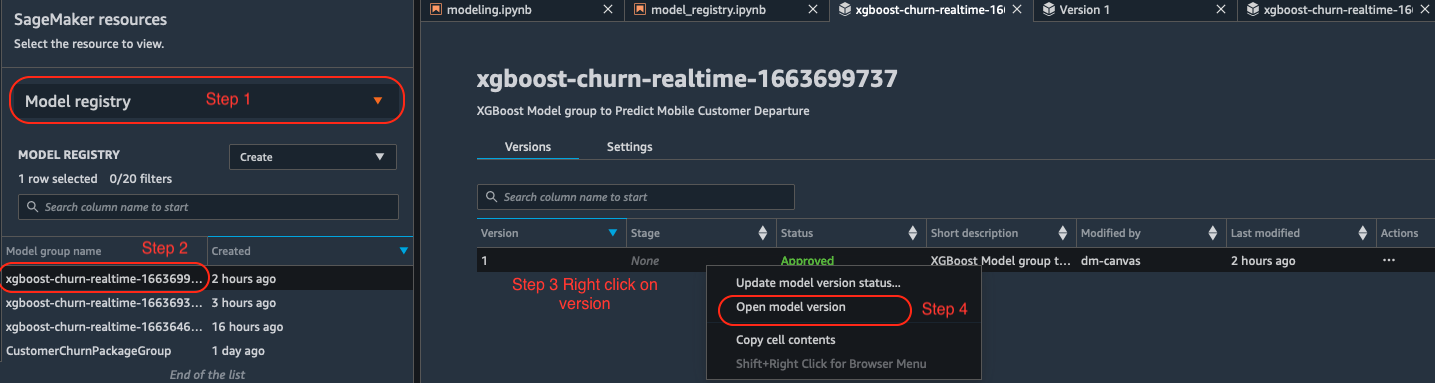

In [52]:
# Store Model Package Arn for use in deployment
%store model_package_arn

Stored 'model_package_arn' (str)


**Endpoint creation**

In [53]:
# Create model ARN using model package registered in registry
from time import gmtime, strftime
model_name = 'workshop-xgboost-customer-churn' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name : {}".format(model_name))
container_list = [{'ModelPackageName': model_package_arn}]

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = container_list
)
print("Model arn : {}".format(create_model_response["ModelArn"]))

Model name : workshop-xgboost-customer-churn2022-09-20-18-49-02
Model arn : arn:aws:sagemaker:us-west-2:917049230680:model/workshop-xgboost-customer-churn2022-09-20-18-49-02


In [54]:
endpoint_config_name = 'workshop-xgboost-customer-churn-epc' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
instance_type = "ml.m4.xlarge"
print(endpoint_config_name)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': instance_type,
        'InitialInstanceCount': 1,
        'InitialVariantWeight': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])
print("Endpoint Configuration Arn: " + create_endpoint_config_response["EndpointConfigArn"])

workshop-xgboost-customer-churn-epc2022-09-20-18-49-03
Endpoint Configuration Arn: arn:aws:sagemaker:us-west-2:917049230680:endpoint-config/workshop-xgboost-customer-churn-epc2022-09-20-18-49-03


In [55]:
endpoint_name = 'workshop-xgboost-customer-churn' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

# wait for endpoint to reach a terminal state (InService) using describe endpoint

describe_endpoint_response = sm_client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = sm_client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

EndpointName=workshop-xgboost-customer-churn2022-09-20-18-49-04
arn:aws:sagemaker:us-west-2:917049230680:endpoint/workshop-xgboost-customer-churn2022-09-20-18-49-04
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'workshop-xgboost-customer-churn2022-09-20-18-49-04',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:917049230680:endpoint/workshop-xgboost-customer-churn2022-09-20-18-49-04',
 'EndpointConfigName': 'workshop-xgboost-customer-churn-epc2022-09-20-18-49-03',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:616702a03550daae343e8e43e23b77ee159dbfa100afc10158b528f26655ca54',
     'ResolvedImage': '246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost@sha256:616702a03550daae343e8e43e23b77ee159dbfa100afc10158b528f26655ca54',
     'ResolutionTime': datetime.datetime(2022, 9, 20, 18, 49, 5, 274000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 9, 20, 18, 49, 4, 678000, tzinfo=tzlocal()),
 'LastModif

View the Model Registry UI to see the endpoint created

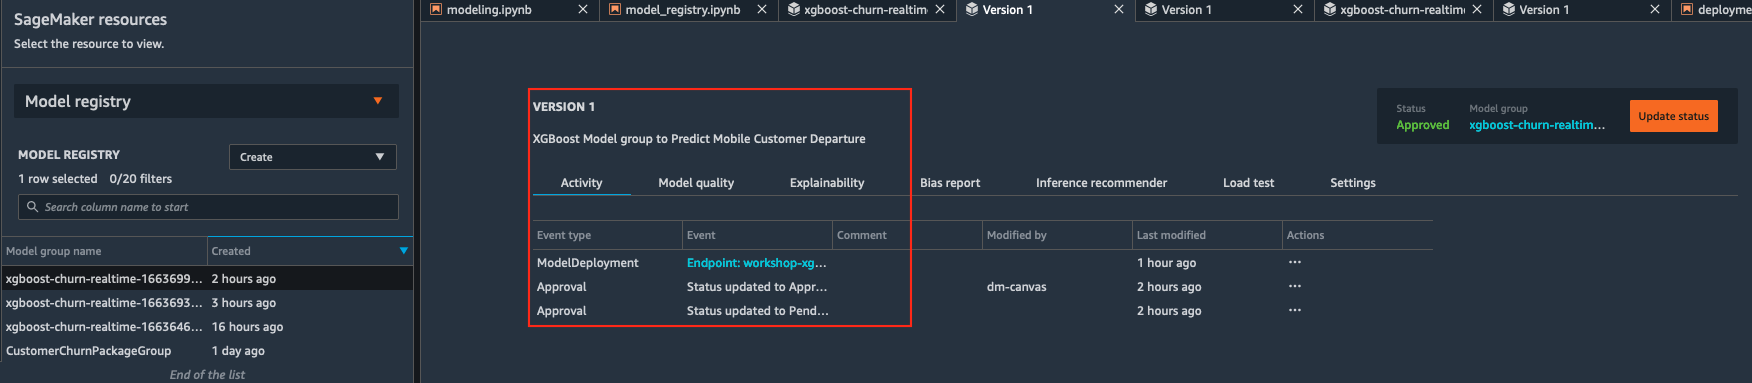

In [58]:
# Once your endpoint has been created we can invoke it with a sample payload and see invocation.

response = sm_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
    ContentType="text/csv",
)

print(response["Body"].read())

b'0.656972348690033\n'
